In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

# spider plot functions
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# clustering functions
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# set plotting functions
matplotlib.rcParams['savefig.dpi'] = 500
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')
# get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
# define functions
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, fontsize=8):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/S00_Strains_Control_Stellate_RNA/'
dataDirectory = '/home/h1bennet/strains/data/RNA/control_lsec/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Import differential gene files for examination and plotting

In [4]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [5]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = ''

In [6]:
gene_list_dict ={}

### Extract "intersection" and "union" gene sets

In [7]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob('./differential/*control*.vs.*control*scatter.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

./differential/aj_stellate_control_young.vs.c57_stellate_control_young.scatter.txt
./differential/aj_stellate_control_young.vs.balbc_stellate_control_young.scatter.txt
./differential/c57_stellate_control_young.vs.balbc_stellate_control_young.scatter.txt
./differential/c57_stellate_control_young.vs.aj_stellate_control_young.scatter.txt
./differential/balbc_stellate_control_young.vs.c57_stellate_control_young.scatter.txt
./differential/balbc_stellate_control_young.vs.aj_stellate_control_young.scatter.txt
./differential/aj_stellate_control_young.vs.c57_stellate_control_young.scatter.txt
./differential/aj_stellate_control_young.vs.balbc_stellate_control_young.scatter.txt
./differential/c57_stellate_control_young.vs.balbc_stellate_control_young.scatter.txt
./differential/c57_stellate_control_young.vs.aj_stellate_control_young.scatter.txt
./differential/balbc_stellate_control_young.vs.c57_stellate_control_young.scatter.txt
./differential/balbc_stellate_control_young.vs.aj_stellate_control_yo

### Write gene lists together for combined GO analysis

In [8]:
meta_df = pd.DataFrame.from_dict(gene_list_dict, orient='index').T
meta_df.to_csv('./gene_lists/all_stellate_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.csv',
               # sep='',
               index=False)

### Try with homer
HOMER is nice because it explicitly tests enrichment in all lists so that
we know we are comparing the same test - metascape does filtering for top 25 or top 100.
    
    for i in *genes*txt; do findGO.pl $i mouse ${i/.txt/_go} -cpu 4; done

### Read in go biological process terms

In [11]:
df_dict = {}
for i in np.sort(glob.glob('./gene_lists/*go/biological_process.txt')):
    df = pd.read_csv(i, sep='\t', index_col=0)
    df_dict[i.split('/')[2].split('_stellate')[0]] = df

# extract subset of terms for spider plot
Unbiased extraction of top three terms

In [12]:
n=3
top_terms = []
for i in ['aj_union', 'balb_union', 'c57_union']:
    top_terms.extend(df_dict[i].sort_values('logP', ascending=True).index.tolist()[:n])
    
top_terms_set = set(top_terms)

# create DF with term IDs and scores

In [13]:
df = df_dict['aj_union'].loc[top_terms_set, ['Term', 'logP']]
df = df.merge(df_dict['balb_union'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('_aj', '_balb'))
df = df.merge(df_dict['c57_union'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('', '_c57'))

# cluster terms
This makes a spider plot in which the strains specific functions are clustered together

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


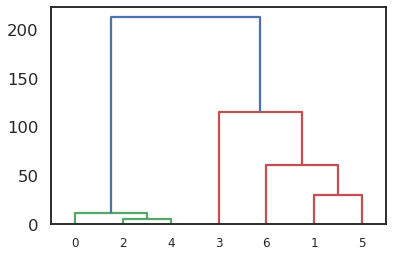

In [14]:
d2 = dist.pdist(df.iloc[:, 1:])
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2)

### Make spider plot

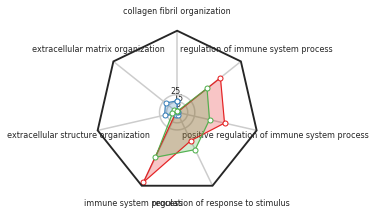

In [15]:
theta = radar_factory(df.shape[0], frame='polygon')
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(projection='radar'))

ax.set_rgrids([5,15,25],
              fontsize=8)

# ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#              horizontalalignment='center', verticalalignment='center')
colors = ['#e41a1c', '#377eb8', '#4daf4a']
lists = ['logP_aj', 'logP_balb', 'logP']

for color, logp_lists in zip(colors, lists):
    ax.plot(theta,
            -df[logp_lists].iloc[Z2['leaves']],
            color=color,
            linewidth=1,
            marker='o',
            markersize=5,
            markerfacecolor='white')
    ax.fill(theta,
            -df[logp_lists].iloc[Z2['leaves']],
            color=color,
            alpha=0.25)
ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                 fontsize=8)

plt.savefig('./figures/spider_plot_top_'+str(n)+'_terms.pdf',
            sep='\t')

# Check whether bar plot is informative
The best way to explain this information is unclear

In [16]:
# # pivot to long format for use in seaborn
# df_long = df.iloc[Z2['leaves'], :].melt(id_vars=['Term'])
# df_long.value = -df_long.value

# sns.catplot(x="value",
#             y="Term",
#             hue="variable",
#             kind="bar",
#             data=df_long)


# Make with custom gene list
Extract top 15 terms per cell type for manual examination

In [17]:
n=15
top_terms = []
for i in ['aj_union', 'balb_union', 'c57_union']:
    top_terms.extend(df_dict[i].sort_values('logP', ascending=True).index.tolist()[:n])
    
top_terms_set = set(top_terms)

df = df_dict['aj_union'].loc[top_terms_set, ['Term', 'logP']]
df = df.merge(df_dict['balb_union'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('_aj', '_balb'))
df = df.merge(df_dict['c57_union'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('', '_c57'))

Look at sorted term list and select terms of interest

In [20]:
df.sort_values('logP').round(3)

,Term,logP_aj,logP_balb,logP
TermID,,,,
GO:0002376,immune system process,-109.932,-4.054,-70.784
GO:0048583,regulation of response to stimulus,-44.603,-3.868,-58.706
GO:0002682,regulation of immune system process,-78.392,-0.642,-54.098
GO:0048584,positive regulation of response to stimulus,-44.404,-6.698,-53.968
GO:0006955,immune response,-68.227,-1.958,-50.306
GO:0002252,immune effector process,-44.690,-7.625,-48.395
GO:0002684,positive regulation of immune system process,-68.813,-1.135,-47.007
GO:0006952,defense response,-51.698,-2.410,-46.505
GO:0007166,cell surface receptor signaling pathway,-27.626,-0.936,-43.467


## Select terms

In [29]:
go_list = ['GO:0006954', 'GO:0009611', 'GO:0007166',
           'GO:0030198', 'GO:0030199', 'GO:0051607',
           'GO:0032964', 'GO:0022610', 'GO:0006952']

# extract merged DF
df = df_dict['aj_union'].loc[go_list, ['Term', 'logP']]
df = df.merge(df_dict['balb_union'].loc[go_list, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('_aj', '_balb'))
df = df.merge(df_dict['c57_union'].loc[go_list, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('', '_c57'))

# cluster terms
This makes a spider plot in which the strains specific functions are clustered together

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


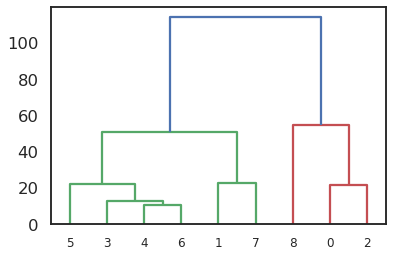

In [30]:
d2 = dist.pdist(df.iloc[:, 1:])
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2)

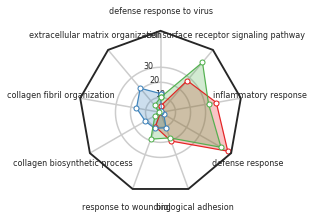

In [31]:
theta = radar_factory(df.shape[0], frame='polygon')
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(projection='radar'))

ax.set_rgrids([10,20,30],
              fontsize=8)

# ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#              horizontalalignment='center', verticalalignment='center')
colors = ['#e41a1c', '#377eb8', '#4daf4a']
lists = ['logP_aj', 'logP_balb', 'logP']

for color, logp_lists in zip(colors, lists):
    ax.plot(theta,
            -df[logp_lists].iloc[Z2['leaves']],
            color=color,
            linewidth=1,
            marker='o',
            markersize=5,
            markerfacecolor='white')
    ax.fill(theta,
            -df[logp_lists].iloc[Z2['leaves']],
            color=color,
            alpha=0.25)
ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                 fontsize=8)

plt.savefig('./figures/spider_plot_curated_terms.pdf',sep='\t')